# Classification Problem



Teamname - The Great Regression (Group 4)

Students - <br>
Elliot Richardson - 202079108, Ana Hernandez - 202058338, Keshan Sharp- 202068088,  Ben-Litherland - 202059817, Viktoriia Khelemska - 202081049 <br>

First we import several libraries that will be useful, some more so later on and others used for 
the EDA.

In [ ]:
import sys
assert sys.version_info >= (3, 5) # Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore') #needed to create the pdf without all the warnings
#!pip install imbalanced-learn

In [ ]:
#importing the data and having a look at it
songs_train = pd.read_csv("CS98XClassificationTrain.csv", na_filter = False)

# Delete null entries
songs_train = songs_train[songs_train["top genre"] != ''] 
songs_train = songs_train.drop(["year","Id", "title", "artist"], axis=1)
songs_train =songs_train.reset_index(drop=True)

**Categorical Data** There are four features which represent categorical data within the training dataset. Title, Artist, Id, and Year. We examined evolution of the numerical feature with respect to year and saw no pertinent trend which would warrant some one-hot encoding of the year data. These are all removed.

### Correlation

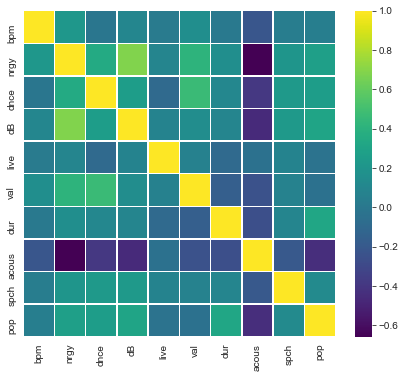

In [100]:
corr = songs_train.corr()
f, ax = plt.subplots(figsize=(7,6))
ax=sns.heatmap(corr,cmap='viridis',linewidths=.5)
sns.set_style("whitegrid")
plt.xticks(rotation=90)
plt.show()

Only a few attributes can be observed to have some mild correlation but none of these are strong enough to warrant removing from our dataset.

**Data Imbalance** There are now 86 unique genre categories that songs can belong to. Lets have a little look at the count of each. 

In [ ]:
songs_count=songs_train["top genre"].value_counts()
songs_count=songs_count.to_frame()
songs_count=songs_count.rename_axis("Top Genre", axis="columns")
songs_count=songs_count.rename(columns={"top genre": "Counts"})

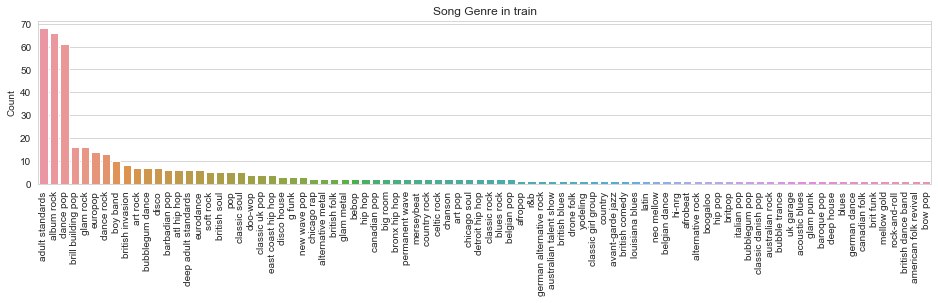

In [101]:
plt.figure(figsize=(16, 3))
ax = sns.barplot(x=songs_count.index, y="Counts", data=songs_count)
ax.set_ylabel('Count')
ax.set_title('Song Genre in train')
sns.set_style("whitegrid")
plt.xticks(rotation=90)
plt.show()

The severity of this dataframes imbalancement makes the modelling challenging. A significant amount of the genres have 16 or under instances. This is little to no data for a model to train on, and creates a biased model as there is much noise. Solutions explored for this are: 

#### A) "Songs Reduced"
Deleting these entries for those less frequent genres, as realistically if they are so unpopular, trading a more accurate classifyer for those popular genres for missclassifying those infrequent ones would be more efficient in terms of accuracy. 


#### B) "Levelled Up" - ROS
Duplicating the entries for those genres with fewer examples, to create a more balanced number of instances per genre. Levelling these to a certain number, leaving the genres with higher frequency as they are. The model has to be trained better for these, as by probability, these will appear more frequently.

#### A) Songs Reduced

In [ ]:
genre = [pd.DataFrame(y) for x, y in songs_train.groupby('top genre', as_index=False)]

In [ ]:
songs_reduced=genre[0]
for i in range(1,len(genre)):
    if len(genre[i])>=3:
        songs_reduced=songs_reduced.append(genre[i],ignore_index=True)
songs_reduced = songs_reduced.iloc[1:]

In [ ]:
from sklearn.utils import shuffle
songs_reduced = shuffle(songs_reduced, random_state=42)
songs_reduced = songs_reduced.reset_index(drop=True)

All instances that had less than 3 instances have been dropped, the new training set has 359 instances and has 26 categories rather than 86. This will cause misclassifications later but we want to improve the behaviour of the classifiers without overfitting to outliers.

## Pre-processing - Label Encoding

In [ ]:
data_train_red=songs_reduced.values[:, 0:-1] #data train
target_train_red=songs_reduced.iloc[:, -1] #target train

In [ ]:
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(target_train_red)
Y_train_prep = le.transform(target_train_red) #encode the target values rather than keep as strings.

## B) ROS
Random Over Sampling is a technique for trying to oversample under represented samples/instances within the data. We will apply this to the Reduced data.

In [ ]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
data_train_resampled, target_train_resampled = ros.fit_resample(data_train_red,target_train_red)

**Scaling Data** - we need to scale the data for both the k-means and later supervised clustering technqiues
We use 2 versions of this, one using random oversampling to increase low instances and the other 'as is'keeping the levels of each genre the same as the original data.

In [ ]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

reduced_train_scaled = std_scaler.fit_transform(data_train_red) #A) Songs Reduced
resampled_train_scaled = std_scaler.fit_transform(data_train_resampled) #B) Levelled Up - ROS

## Feature Engineering

Given that many genre's in this dataset are subsets of a bigger genre (eg. dance pop, europop, new wave pop... all belong to pop), we attempted grouping sub genre's under more generalized labels. This could lead to a classifier that maybe wouldn't specify the type of 'pop' but would be able to differenciate between more widespread genre's like 'pop', 'rock', 'blues', 'orchestra', etc...
#### K-Means clustering
Here I tried to see if unsupervised methods could apply som pre-labeling to the data as features to help in the supervised aspect. I checked a range of clusters, for the training set k=86 is logical given the number of categories but that is unlikely to be found.

In [ ]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(resampled_train_scaled) for k in range(1, 100)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(resampled_train_scaled, model.labels_) for model in kmeans_per_k[1:]]

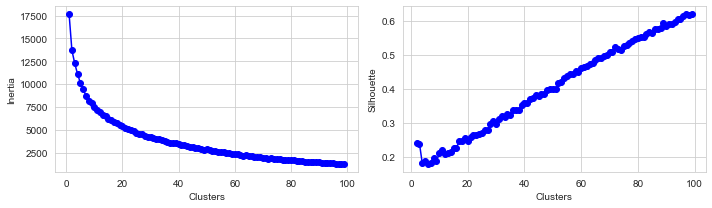

In [102]:
f = plt.figure(figsize=(10,3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(range(1, 100), inertias, "bo-")
ax2.plot(range(2, 100), silhouette_scores, "bo-")
ax1.set_xlabel('Clusters')
ax2.set_xlabel('Clusters')
ax1.set_ylabel('Inertia')
ax2.set_ylabel('Silhouette')
plt.tight_layout()
plt.show()

The inertia plot shows no clear elbow and so we will look at the silhouette plot to guide addition of cluster information.The silhouette also doesn't show us anything useful in terms of unsupervised learning techniques to try and put pre-labels onto the data. This will not be added to the training data as categorical information.

**Dimensional Reduction - PCA Analysis**<BR>

Here we will run the data through some PCA analysis to see if we can reduce the workload on our classifiers

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
X2D = pca.fit_transform(reduced_train_scaled)
data_train_reduced = pca.fit_transform(reduced_train_scaled)

In [ ]:
print(pca.explained_variance_ratio_)

So taking the 10 features we started with and reducing it to 9 we describe 95% of the variance. I don't think there's much value in keeping this PCA in the assessment given this isn't a significant reduction in dimension. Therefore, we decided not to apply this to our dataset.

# Classification


Now that the data has been cleaned up and analysed, some classification will be carried out. We will start using simple classifiers and then move on to some more complex ensembling methods. 

For this, we will use a combination of the different datasets we prepared (A, B, C) explained above. We found that some worked better for some classifiers and others worked better for others. So we decided not to stick to one method of data mining. Data C) "Levelled up" - SMOTE, simulated 63 instances of each category.

We will use stratified k-folding to create train/test folds of our training CSV file in order for the models to learn using an even distribution of genre's within it. 


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

#Get some stratified folds using the oversampled data, bringing the all instances up to 68.
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
skf.get_n_splits(resampled_train_scaled,target_train_resampled)

#Getting a 1/3 split from the training data without oversampling applied
skf.get_n_splits(reduced_train_scaled,Y_train_prep)

## Simple classifiers

Firstly we looked at building some simple classifiers, we built 3 simple classifiers of Naive Bayes, K nearest Neighbour, and Linear SVC.

Evaluating the three simple classifiers none of them score particularly well on unseen data. Normally these simple classifiers are good as they avoid overfitting the data but given the number of instances of a single genre they seem to really be struggling. We will try to build some ensemble learners to try and improve on their shortfalling.

## Ensemble classification

Several ensemble techniques were employed; Adaboost with descision Tree, Stacking with bagging, and a soft voting classifier. It was found that these all outperformed the simple classifiers on the training data amd seemed to score between 30 and 40% accuracy when compared to each other. 

The stacking classifier used bagged or boosted SVC, Logistic regression, RandomForest, and Descision tree techniques. While it performed well in the training data it didn't hold up when the predictions were tested on Kaggle.

We believe this is because the Stacking classifier was overfitting the data we supplied it and also that the estimators that comprised it are too similar. This introduced bias favouring those estimator which were similar.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

**Voting Classifier**<br>
We build a voting classifier using 2 of our simple classifiers and an adaboosted decision tree.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

print("\n\n Ensemble Voting CLF")
print("**************************************")

LR_clf=clf = LogisticRegression(random_state=0)
KNN_clf = KNeighborsClassifier(weights='distance')
ADA_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=600,algorithm="SAMME.R", learning_rate=0.2)

eclf1 = VotingClassifier(estimators=[('knn', KNN_clf),('ada_rf', ADA_clf),("LR",LR_clf)], voting='soft')

for train_index, test_index in skf.split(reduced_train_scaled,Y_train_prep):
    X_train, X_test = reduced_train_scaled[train_index], reduced_train_scaled[test_index]
    y_train, y_test = Y_train_prep[train_index], Y_train_prep[test_index]
    eclf1.fit(X_train, y_train)
    
VOTE_predicted = eclf1.predict(X_test)
print(accuracy_score(y_test, VOTE_predicted))

The voting classifier utilised Logistic regression, K-Nearest neighbour, and an adaboosted Descision tree. These different estimtors will make errors/misclassifications on different areas of the data and thus balance each other out. The soft voting method takes into account the confidence measure of each of its component estimators, which the stacking estimator didn't.

## Competition predictions

Here we use the test CSV to generate our final predictions for submission

In [ ]:
songs_test_full = pd.read_csv("CS98XClassificationTest.csv",na_filter=False)
songs_test = songs_test_full.drop(["year","Id", "title", "artist"], axis=1)
test_scaled = std_scaler.fit_transform(songs_test)

In [ ]:
VOTE_preds=eclf1.predict(test_scaled)
VOTEtarget_label=le.inverse_transform(VOTE_preds)
predictions=pd.DataFrame(VOTEtarget_label)
predictions['Id']=songs_test_full['Id']
predictions.columns = ['top genre', 'Id']
predictions.to_csv('predictions.csv', index = False)

In [103]:
np.unique(VOTEtarget_label)

array(['adult standards', 'album rock', 'brill building pop', 'dance pop',
       'glam rock', 'pop'], dtype=object)

## **Kaggle Score** - 0.26785

# Conclusions

Our final classifier (voting classifier) scores only 0.26785 in the competition and basically only predicts the top three most frequent genre's within the training set. It's possible we needed some more feature engineering but really this was a struggle with an uneven testing dataset. Out of our original 86 categories (reduced to 27 using data with only 3 or more instances) our estimator only guesses 8 of them.

The main genre's that the estimators predict are "Adult Standards", "Album Rock", and "Dance pop", which we strongly suspect is due to their prevelence in the training data. In the future a more balanced set of training data would be desirable.

It is interesting how a voting classifier using three classifiers works better than the stacking model with 5 boosted or bagged classifiers. It almost scores as highly as all these individually, which is concerning.

Collection of more data would have been the most optimal solution in our opinion, as little can a model learn from single instances about an entire music genre, there is so much information to this. Not even qualified musicians can sometimes categorize properly certain songs, or can disagree with others, as a song's genre is a very narrow way of clustering music, when songs can sometimes be so unique and not similar to any others examples.